## Coursera Capstone: Opening a Specialty Bakery in the city of Toronto, Canada

## Introduction

For the Capstone project, I am reviewing the scenario in which an enterpreneur wants to explore the possibility of opening a new organic bakery in the city of Toronto, Canada. The bakery will specialize in gluten, wheat and dairy free products. In the last years, there has been a noticeable improvement in the diagnosis of food allergies. Previously, what was an unknown problem which affected many people has become in a manageable ailment which is easily treated through modification of diets.

## Business Problem

The new bakery aims to offer products targeted to people who suffer from food allergies. The range of products offered will be spelt breads, muffins and pastries. Spelt will be used since there are less people who are allergic to this grain. A range of yeast-free breads, dairy-free muffins and pastries, as well as egg-free products will be offered.

The new specialty bakery will focus on two customer segments. One is the Allergy segment and the second is the Dieter segment, consisting of people who are making modifications in their diet based on a desire to lose weight.

## Table of Contents

1. Data acquisition
2. Exploring the Neighborhoods of Toronto
3. Analysis of each Neighborhood
4. Clustering the Neighborhoods
5. Examine the Clusters
6. Discussion of the results
7. Conclusion

First, we will import the required dependencies for the analysis

In [209]:
import  numpy as np #Library to handle data in vectorized form
import pandas as pd #Library for Data Analysis
import json #Library to handle JSON files
import requests #Library to handle requests
from pandas.io.json import json_normalize #Transform JSON file into pandas data frame

#Matplotlib and plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#Import k-means from sklearn
from sklearn.cluster import KMeans

#Import map rendering library
import folium

import matplotlib.pyplot as plt

## Data acquisition

We will obtain the list of Toronto neighborhoods from the Wikipedia page "List of postal codes of Canada: M". In this list postal codes beginning with M correspond to the city of Toronto. A pandas data frame will be created, ignoring the records for which the name of the Borough was not assigned

In [210]:
data_table=pd.read_html('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=862527922',header=0)
df1=data_table[0]
df_clean=df1[df1['Borough']!='Not assigned']
df_clean.head()


,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


In [211]:
#Find its shape
df_clean.shape

(212, 3)

Wherever we have Neighborhoods belonging to the same postal code, we will combine them into one row, separating the Neighborhoods by a comma

In [212]:
df_join = df_clean.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()
df_join.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [213]:
#Find the shape
df_join.shape

(103, 3)

Records for which the Neighborhood name is 'Not Assigned' will be replaced by the Borough name

In [214]:
df_final = df_join
df_final.loc[df_final['Neighbourhood']=='Not assigned','Neighbourhood']=df_final.loc[df_final['Neighbourhood']=='Not assigned']['Borough']

#An example of this case corrsponds to Postcode M7A:
df_final[df_final['Postcode']=='M7A']

,Postcode,Borough,Neighbourhood
85,M7A,Queen's Park,Queen's Park


In [215]:
#The number of rows in the rearranged data set is:
df_final.shape[0]

103

#### Assign the geographical coordinates
The next step is to assign the geographical coordinates for each neighborhood. For this purpose, I will use the data set http://cocl.us/Geospatial_data, which contains coordinates (latitude and longitude) for each postal code

In [216]:
geo = pd.read_csv('http://cocl.us/Geospatial_data')
geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


We need to rename the first column of the acquired data frame (it is named Postal Code, rather than Post Code) in order to merge it with our existing data frame (df_final)

In [217]:
geo.columns = ['Postcode', 'Latitude', 'Longitude']
df_final = pd.merge(geo, df_final, on='Postcode')

Reordering the column names in the merged data frame, containing the latitude and longitude of each neighborhood

In [218]:
df_final = df_final[['Postcode', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude']]
df_final.head()


,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [219]:
#Checking the shape of the merged data frame
df_final.shape

(103, 5)

#### Create a map of Toronto with Neighborhoods superimposed

In [220]:
import folium

tlat=43.653963
tlong=-79.387207
torontoMap=folium.Map(location=[tlat,tlong],zoom_start=10.7)

for lat,long,borough,neighborhood in zip(df_final['Latitude'],df_final['Longitude'],df_final['Borough'],df_final['Neighbourhood']):
    label='{}, {}'.format(neighborhood,borough)
    label=folium.Popup(label,parse_html=True)
    folium.CircleMarker([lat,long],
                       radius=5,
                       popup=label,
                       color='blue',
                       fill=True,
                       fill_color='#3186cc',
                       fill_opacity=0.7,
                       parse_html=False).add_to(torontoMap)
    
torontoMap

Finding the boroughs that contain the word Toronto

In [221]:
torontoData = df_final[df_final['Borough'].str.contains('Toronto')].reset_index(drop=True)
torontoData.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [222]:
#Display shape of the data frame
torontoData.shape

(38, 5)

Create a visualization of the Boroughs that contain Toronto in their name

In [223]:
torontonameMap=folium.Map(location=[tlat,tlong],zoom_start=12)
for lat,long,label in zip(torontoData['Latitude'],torontoData['Longitude'],torontoData['Neighbourhood']):
    label=folium.Popup(label,parse_html=True)
    folium.CircleMarker([lat,long],
                       radius=5,
                       popup=label,
                       color='blue',
                       fill=True,
                       fill_color='#3186cc',
                       fil_opacity=0.7,
                       parse_html=False).add_to(torontonameMap)
torontonameMap

Define the Foursquare credentials and version

In [224]:
CLIENT_ID='OCAZNCAZQIXBS3DO52YEIUSZDUVF1N1GEMMCISX12RUEK41C'
CLIENT_SECRET='XLHVDTTDJZ3ZZBJQ2IMWZGUUYYWH2MFXBKGWGM4JTTIAVFDJ'
VERSION='20180605'
print('Your credentials:')
print('Client ID:  '+ CLIENT_ID)
print('Client Secret:  '+CLIENT_SECRET)

Your credentials:
Client ID:  OCAZNCAZQIXBS3DO52YEIUSZDUVF1N1GEMMCISX12RUEK41C
Client Secret:  XLHVDTTDJZ3ZZBJQ2IMWZGUUYYWH2MFXBKGWGM4JTTIAVFDJ


Obtaining the top 200 venues located within Boroughs with Toronto in their name within a radius of 500 m

In [225]:
LIMIT = 200
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{},&radius={}&limit={}'.format(
       CLIENT_ID,
       CLIENT_SECRET,
       VERSION,
       tlat,
       tlong,
       radius,
       LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?client_id=OCAZNCAZQIXBS3DO52YEIUSZDUVF1N1GEMMCISX12RUEK41C&client_secret=XLHVDTTDJZ3ZZBJQ2IMWZGUUYYWH2MFXBKGWGM4JTTIAVFDJ&v=20180605&ll=43.653963,-79.387207,&radius=500&limit=200'

Sending the get request and examining the result

In [226]:
import requests
import json
results=requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ef1397b9388d7001bfce145'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bay Street Corridor',
  'headerFullLocation': 'Bay Street Corridor, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 45,
  'suggestedBounds': {'ne': {'lat': 43.6584630045, 'lng': -79.38099903084075},
   'sw': {'lat': 43.649462995499995, 'lng': -79.39341496915925}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5227bb01498e17bf485e6202',
       'name': 'Downtown Toronto',
       'location': {'lat': 43.65323167517444,
        'lng': -79.38529600606677,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65323167517444,
          

The next step is to define a function that will interact with FourSquare API and get top 100 venues within a radius of 500 metres for a given latitude and longitude. The function will return a dataframe with columns as venue id , venue name and category.

In [227]:
#This function extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We will clean the json and structure it into a pandas dataframe

In [228]:
from pandas.io.json import json_normalize
venues=results['response']['groups'][0]['items']
venuesNearBy=json_normalize(venues)

# filter columns
filtered_columns=['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
venuesNearBy=venuesNearBy.loc[:, filtered_columns]

# clean columns
venuesNearBy.columns = [col.split(".")[-1] for col in venuesNearBy.columns]

venuesNearBy.head()

,name,categories,lat,lng
0,Downtown Toronto,"[{'id': '4f2a25ac4b909258e854f55f', 'name': 'N...",43.653232,-79.385296
1,Textile Museum of Canada,"[{'id': '4bf58dd8d48988d18f941735', 'name': 'A...",43.654396,-79.386500
2,Rolltation,"[{'id': '4bf58dd8d48988d111941735', 'name': 'J...",43.654918,-79.387424
3,Cafe Plenty,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",43.654571,-79.389450
4,Sansotei Ramen 三草亭,"[{'id': '55a59bace4b013909087cb24', 'name': 'R...",43.655157,-79.386501


### Exploring the Neighborhoods of Toronto

We will create a function to get the top 200 venues within a radius of 500 m from each neighborhood

In [229]:
def get_venues(lat,lng):
    
    #set variables
    radius=500
    LIMIT=200
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id = row['venue']['id']
            venue_name = row['venue']['name']
            venue_category = row['venue']['categories'][0]['name'] # Get category of Venue
            venue_lat = row['venue']['location']['lat'] 
            venue_lng = row['venue']['location']['lng'] 
            venue_details.append([venue_id,venue_name,venue_category,venue_lat,venue_lng])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category','Lat','Lng']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

The next function will get venue details such as user ratings, likes and count of tips

In [230]:
def get_venue_details(venue_id):
  
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

The next step is to write the code to get the list of venues from each neighborhood in Toronto, including name, category and geographical coordinates

In [231]:
# prepare data frame containing list of venues in neighborhoods of Toronto
column_names=['Postcode','Borough', 'Neighborhood', 'N_Lat','N_Lng','ID','Name','Category','Lat','Lng']
venues_torontnew=pd.DataFrame(columns=column_names)

for row in df_final.values.tolist():
    Postcode, Borough, Neighbourhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    # return only relevant information for each nearby venue
    for venue in venues.itertuples():
        venues_torontnew = venues_torontnew.append({
            'Postcode':Postcode,
            'Borough':Borough,
            'Neighborhood': Neighbourhood,
            'N_Lat':Latitude,
            'N_Lng':Longitude,
            'ID':venue.ID,#['ID'],
            'Name':venue.Name,#['Name'],
            'Category':venue.Category,#['Category'],
            'Lat':venue.Lat,#['Lat'],
            'Lng':venue.Lng#['Lng']
        }, ignore_index=True)
        
venues_torontnew.head()

,Postcode,Borough,Neighborhood,N_Lat,N_Lng,ID,Name,Category,Lat,Lng
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,4bb6b9446edc76b0d771311c,Wendy’s,Fast Food Restaurant,43.807448,-79.199056
1,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,5539e7d2498edaf4b02673ca,Interprovincial Group,Print Shop,43.805630,-79.200378
2,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,4c23d3aaf7ced13a5ed7216d,Royal Canadian Legion,Bar,43.782533,-79.163085
3,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,4beee041e24d20a1cd857314,RBC Royal Bank,Bank,43.766790,-79.191151
4,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,4c62f34bde1b2d7fec89e370,G & G Electronics,Electronics Store,43.765309,-79.191537


In [232]:
#Finding how many venues were returned for the neighborhoods of Toronto
venues_torontnew.shape

(2108, 10)

We need to find out how many bakeries and bakeshops specialized in the the types of products that we intend to sell as cupcakes, donuts, muffins are located in the Toronto area

In [233]:
toronto_bakery = venues_torontnew[venues_torontnew.Category.str.contains('Bakery')]
toronto_bakery.shape

(43, 10)

In [234]:
toronto_donut = venues_torontnew[venues_torontnew.Category.str.contains('Donut')]
toronto_donut.shape

(3, 10)

In [235]:
toronto_cupcake = venues_torontnew[venues_torontnew.Category.str.contains('Cupcake')]
toronto_cupcake.shape

(2, 10)

In [236]:
toronto_dessert = venues_torontnew[venues_torontnew.Category.str.contains('Dessert')]
toronto_dessert.shape

(14, 10)

In [237]:
toronto_patisserie = venues_torontnew[venues_torontnew.Category.str.contains('Patisserie')]
toronto_patisserie.shape

(0, 10)

In [238]:
frames = [toronto_bakery, toronto_donut, toronto_cupcake, toronto_dessert]

In [239]:
toronto_bakeryshop = pd.concat(frames)
toronto_bakeryshop.shape

(62, 10)

Our search contains 61 results

In [240]:
toronto_bakeryshop.head()

,Postcode,Borough,Neighborhood,N_Lat,N_Lng,ID,Name,Category,Lat,Lng
18,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,4e42cfc56284d1faa44a1083,B&A Bakery,Bakery,43.774391,-79.243877
37,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,4cb6527eb315a0934c469b76,Bakery On The Go,Bakery,43.711271,-79.279506
38,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,4eb2c6918b815ab741f9fcdd,Cafe on the go,Bakery,43.711151,-79.279469
54,M1R,Scarborough,"Maryvale, Wexford",43.750072,-79.295849,569d1d81498e73b3eba22d2f,Crown Pastries,Bakery,43.746098,-79.293142
99,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,4bbaa0f17421a5937311c440,Michel's Baguette,Bakery,43.777082,-79.344557


Plotting the bakeries in a map of Toronto

In [241]:
# create map of Bakeries in Toronto using geographical coordinates
Toronto_bakemap = folium.Map(location=[tlat, tlong], zoom_start=10)

# add markers to map
for lat, lng, name, neighborhood in zip(toronto_bakeryshop['Lat'], toronto_bakeryshop['Lng'], toronto_bakeryshop['Name'], toronto_bakeryshop['Neighborhood']):
    label = '{}, {}'.format(name, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_bakemap)  
    
Toronto_bakemap

Plotting the number of bakeries in each Borough:

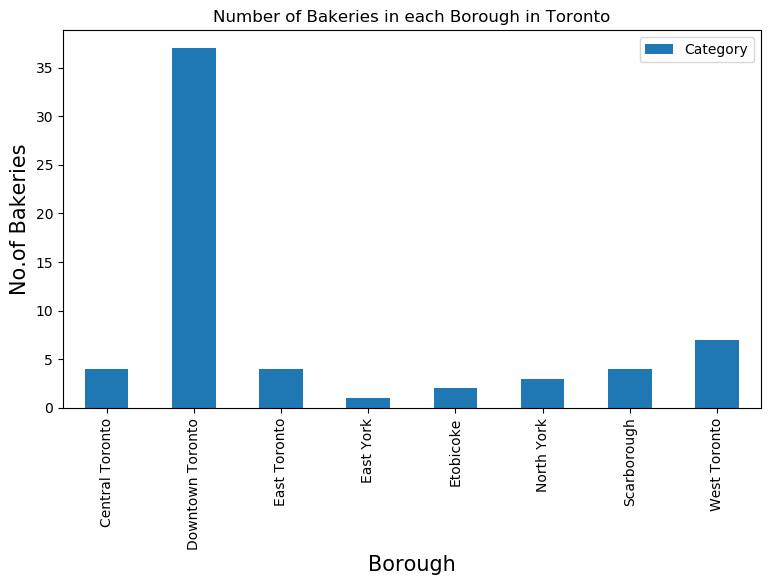

In [242]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Bakeries in each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Bakeries', fontsize=15)
#giving a bar plot
toronto_bakeryshop.groupby('Borough')['Category'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

The majority of the bakeries are located in Downtown Toronto, followed by West and Central Toronto. We will plot the number of bakeries in each neighborhood

In [243]:
toronto_bakeryshop.groupby('Neighborhood').count()

,Postcode,Borough,N_Lat,N_Lng,ID,Name,Category,Lat,Lng
Neighborhood,,,,,,,,,
"Adelaide, King, Richmond",3,3,3,3,3,3,3,3,3
Berczy Park,2,2,2,2,2,2,2,2,2
"Brockton, Exhibition Place, Parkdale Village",1,1,1,1,1,1,1,1,1
"Cabbagetown, St. James Town",3,3,3,3,3,3,3,3,3
Cedarbrae,1,1,1,1,1,1,1,1,1
Central Bay Street,2,2,2,2,2,2,2,2,2
"Chinatown, Grange Park, Kensington Market",6,6,6,6,6,6,6,6,6
"Clairlea, Golden Mile, Oakridge",2,2,2,2,2,2,2,2,2
"Commerce Court, Victoria Hotel",2,2,2,2,2,2,2,2,2


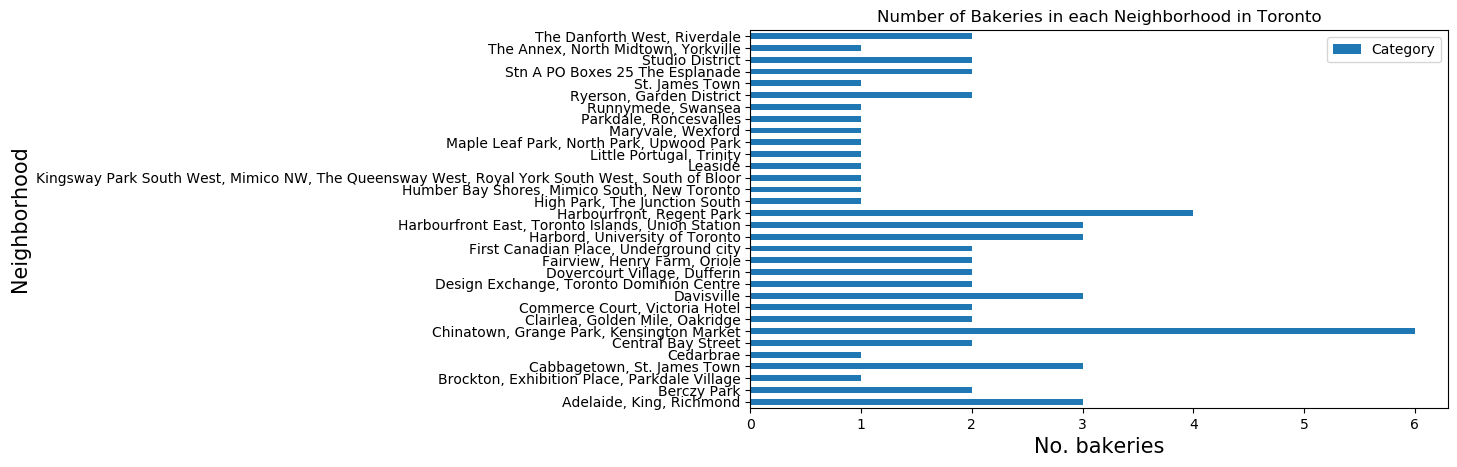

In [244]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Bakeries in each Neighborhood in Toronto')
#On x-axis
plt.xlabel('No. bakeries', fontsize = 15)
#On y-axis
plt.ylabel('Neighborhood', fontsize=15)
#giving a bar plot
toronto_bakeryshop.groupby('Neighborhood')['Category'].count().plot(kind='barh')
#legend
plt.legend()
#displays the plot
plt.show()

### Analyzing details for each  Borough and Neighborhoods

Next, we will explore ratings including user ratings, likes and total tips provided by users of Foursquare
We will use these variables to cluster the bakeries and to get an insight on the consumer preferences (sentiment) for each of these bakeries

In [245]:
# Data frame containing list of Bakeries with likes, ratings and tips
column_names=['Postcode', 'Borough', 'Neighborhood', 'Lat', 'Lng', 'ID','Name','Likes','Rating','Tips']
bakeries_likes_tor=pd.DataFrame(columns=column_names)

for row in toronto_bakeryshop.values.tolist():
    Postcode, Borough, Neighborhood, N_Lat, N_Lng, ID, Name, Category, Lat, Lng = row
    try:
        venue_detl = get_venue_details(ID)
        id,name,likes,rating,tips=venue_detl.values.tolist()[0]
    except IndexError:
        # If there are no details available, we will give all 0
        id,name,likes,rating,tips=[0]*5
        
    # Collect results in a dataframe
    bakeries_likes_tor = bakeries_likes_tor.append(
                                                {
                                                    'Postcode': Postcode,
                                                    'Borough':Borough,
                                                    'Neighborhood':Neighborhood,
                                                    'Lat':Lat,
                                                    'Lng':Lng,
                                                    'ID':ID,
                                                    'Name':Name,
                                                    'Likes':likes,
                                                    'Rating':rating,
                                                    'Tips':tips
                                                }, ignore_index=True
                                                )
    
bakeries_likes_tor.head()

,Postcode,Borough,Neighborhood,Lat,Lng,ID,Name,Likes,Rating,Tips
0,M1H,Scarborough,Cedarbrae,43.774391,-79.243877,4e42cfc56284d1faa44a1083,B&A Bakery,7,6.4,3
1,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711271,-79.279506,4cb6527eb315a0934c469b76,Bakery On The Go,0,0.0,0
2,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711151,-79.279469,4eb2c6918b815ab741f9fcdd,Cafe on the go,0,0.0,0
3,M1R,Scarborough,"Maryvale, Wexford",43.746098,-79.293142,569d1d81498e73b3eba22d2f,Crown Pastries,7,7.8,1
4,M2J,North York,"Fairview, Henry Farm, Oriole",43.777082,-79.344557,4bbaa0f17421a5937311c440,Michel's Baguette,26,7.1,12


In order to view some statistical details of the data frame, we need to make sure that the variables Rating, Tips and Likes are of integer type

In [246]:
bakeries_likes_tor['Likes'] = bakeries_likes_tor['Likes'].astype('int64')
bakeries_likes_tor['Rating'] = bakeries_likes_tor['Rating'].astype('int64')
bakeries_likes_tor['Tips'] = bakeries_likes_tor['Tips'].astype('int64')

bakeries_likes_tor.dtypes

Postcode         object
Borough          object
Neighborhood     object
Lat             float64
Lng             float64
ID               object
Name             object
Likes             int64
Rating            int64
Tips              int64
dtype: object

Now we can view a summary of statistics related to the data frame

In [247]:
bakeries_likes_tor.describe()

,Lat,Lng,Likes,Rating,Tips
count,62.000000,62.000000,62.000000,62.000000,62.000000
mean,43.666884,-79.385207,30.983871,6.806452,13.338710
std,0.034027,0.047598,42.126465,1.948843,16.294365
min,43.601403,-79.518172,0.000000,0.000000,0.000000
25%,43.648734,-79.402499,8.000000,7.000000,4.000000
50%,43.654879,-79.380850,16.000000,7.000000,7.500000
75%,43.667365,-79.368441,32.750000,8.000000,15.750000
max,43.777082,-79.243877,199.000000,9.000000,89.000000


We can use box plots to visualize the distribution of Likes, Rating and Tips in the different Boroughs

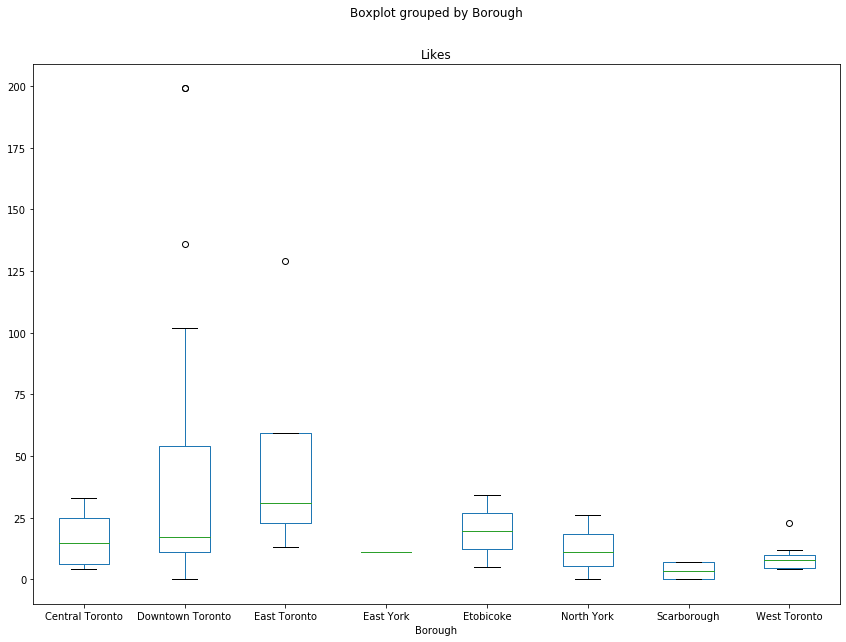

In [248]:
#Box plot of Likes distribution in the different Boroughs
bakeries_likes_tor.boxplot(by='Borough', column=['Likes'], grid=False, figsize=[14,10])

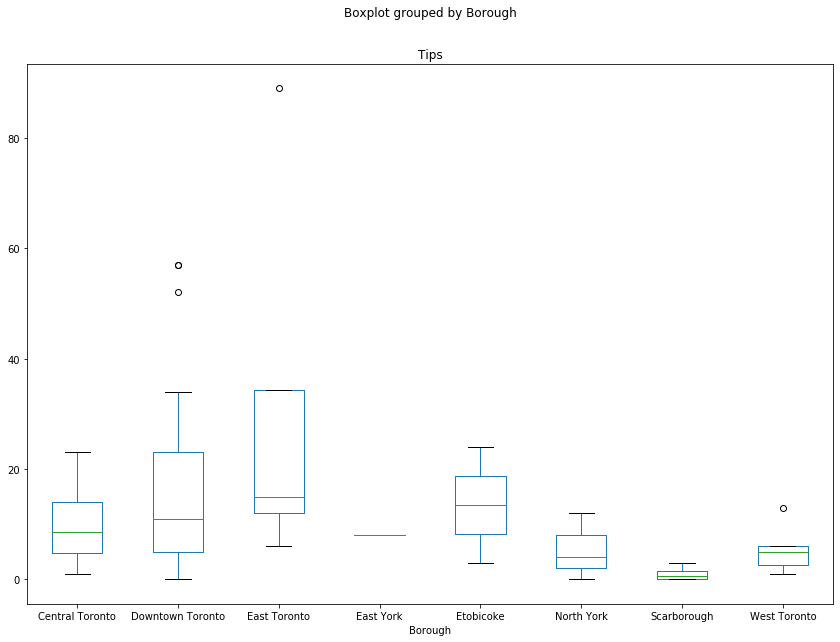

In [249]:
#Box plot of Tips distribution in the different Boroughs
bakeries_likes_tor.boxplot(by='Borough', column=['Tips'], grid=False, figsize=[14,10])

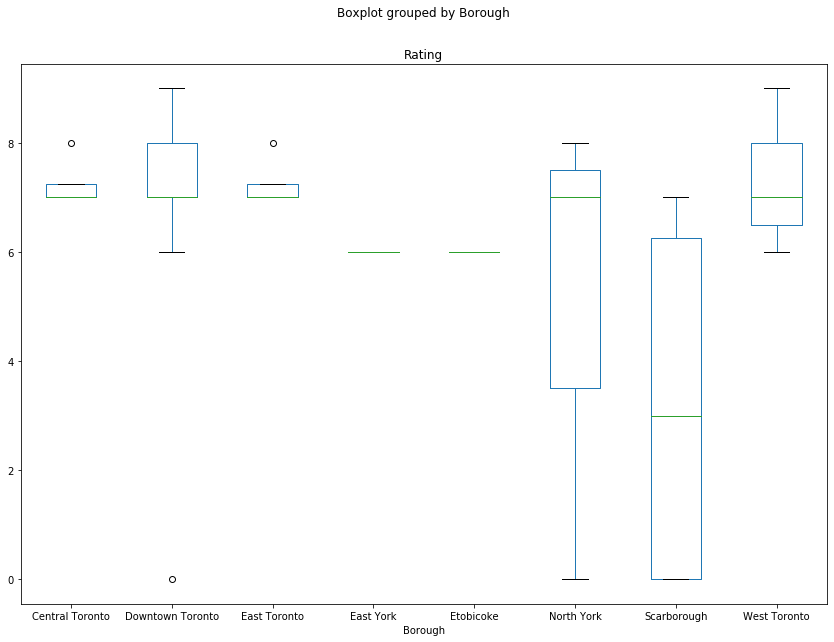

In [250]:
#Box plot of Rating distribution in the different Boroughs
bakeries_likes_tor.boxplot(by='Borough', column=['Rating'], grid=False, figsize=[14,10])

The boxplots show that in general bakeries located in Downtown Toronto and West Toronto have received the highest ratings and that people have given more likes to bakeries in Downtown and East Toronto

### Clustering the Neighborhoods

We will run k-means to cluster the neighborhoods according to the bakeries ratings, likes and tips

In [251]:
bakeries_torclustering = bakeries_likes_tor.loc[:,['Likes','Rating','Tips']]
bakeries_torclustering.head()

,Likes,Rating,Tips
0,7,6,3
1,0,0,0
2,0,0,0
3,7,7,1
4,26,7,12


We will use the Elbow method to assess the optimal number of clusters to be used in k-means

In [252]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(bakeries_torclustering)
bakeries_transformed = mms.transform(bakeries_torclustering)

In [253]:
Sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters =k)
    km = km.fit(bakeries_transformed)
    Sum_of_squared_distances.append(km.inertia_)

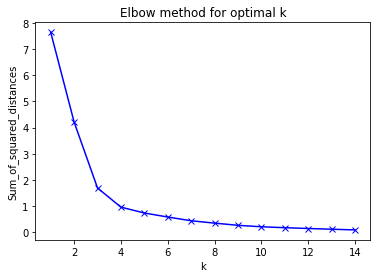

In [254]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow method for optimal k')
plt.show()

In the figure above, the elbox is at k=4, indicating that the optimal number of clusters for the data set is 4

In [255]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bakeries_torclustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 1, 1, 2, 0, 3, 0, 0, 0], dtype=int32)

In [256]:
#bakeries_likes_tor.insert(0,'ClusterLabels', kmeans.labels_)
bakeries_likes_tor['ClusterLabels'] = kmeans.labels_
bakeries_likes_tor.head()

,Postcode,Borough,Neighborhood,Lat,Lng,ID,Name,Likes,Rating,Tips,ClusterLabels
0,M1H,Scarborough,Cedarbrae,43.774391,-79.243877,4e42cfc56284d1faa44a1083,B&A Bakery,7,6,3,0
1,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711271,-79.279506,4cb6527eb315a0934c469b76,Bakery On The Go,0,0,0,0
2,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711151,-79.279469,4eb2c6918b815ab741f9fcdd,Cafe on the go,0,0,0,0
3,M1R,Scarborough,"Maryvale, Wexford",43.746098,-79.293142,569d1d81498e73b3eba22d2f,Crown Pastries,7,7,1,0
4,M2J,North York,"Fairview, Henry Farm, Oriole",43.777082,-79.344557,4bbaa0f17421a5937311c440,Michel's Baguette,26,7,12,0


### Examine the Clusters

Visualizing the resulting clusters in a map

In [257]:
# create map
map_clusters = folium.Map(location=[tlat, tlong], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bakeries_likes_tor['Lat'], bakeries_likes_tor['Lng'], bakeries_likes_tor['Neighborhood'], bakeries_likes_tor['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Examining the clusters

### Cluster 1 (Red in the map)

In [258]:
bakeries_likes_tor.loc[bakeries_likes_tor['ClusterLabels'] == 0, bakeries_likes_tor.columns[[1,2] + list(range(5, bakeries_likes_tor.shape[1]))]]

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips,ClusterLabels
0,Scarborough,Cedarbrae,4e42cfc56284d1faa44a1083,B&A Bakery,7,6,3,0
1,Scarborough,"Clairlea, Golden Mile, Oakridge",4cb6527eb315a0934c469b76,Bakery On The Go,0,0,0,0
2,Scarborough,"Clairlea, Golden Mile, Oakridge",4eb2c6918b815ab741f9fcdd,Cafe on the go,0,0,0,0
3,Scarborough,"Maryvale, Wexford",569d1d81498e73b3eba22d2f,Crown Pastries,7,7,1,0
4,North York,"Fairview, Henry Farm, Oriole",4bbaa0f17421a5937311c440,Michel's Baguette,26,7,12,0
5,North York,"Fairview, Henry Farm, Oriole",51366c4be4b0b3485adfcbf9,Michel's Baguette,0,0,0,0
6,East Toronto,"The Danforth West, Riverdale",4aec8fe3f964a520bcc821e3,Dough Bakeshop,13,8,6,0
7,East Toronto,Studio District,4ae0cc28f964a5209d8221e3,Brick Street Breads,26,7,16,0
9,Downtown Toronto,"Cabbagetown, St. James Town",4ae394fcf964a520e99621e3,Absolute Bakery & Café,15,7,8,0
10,Downtown Toronto,"Cabbagetown, St. James Town",4b6c81a1f964a5207d3f2ce3,Daniel et Daniel Event Creation & Catering,5,6,10,0


Cluster 1 is the cluster with higher concentration of bakeries located spread in the area of Downtown Toronto and West Toronto, with approximately 30% of them having a high rating and the other 70% just an average rating

### Cluster 2 (Purple in the map)

In [259]:
bakeries_likes_tor.loc[bakeries_likes_tor['ClusterLabels'] == 1, bakeries_likes_tor.columns[[1,2] + list(range(5, bakeries_likes_tor.shape[1]))]]

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips,ClusterLabels
54,Downtown Toronto,"Ryerson, Garden District",55074b57498ef35eeeaafe29,Uncle Tetsu's Cheesecake (Uncle Tetsu's Japane...,199,7,57,1
55,Downtown Toronto,Central Bay Street,55074b57498ef35eeeaafe29,Uncle Tetsu's Cheesecake (Uncle Tetsu's Japane...,199,7,57,1


Cluster 2 is located in Downtown Toronto, in Little Tokyo. This cluster has the bakery with the highest number of likes

### Cluster 3 (Blue in the map)

In [260]:
bakeries_likes_tor.loc[bakeries_likes_tor['ClusterLabels'] == 2, bakeries_likes_tor.columns[[1,2] + list(range(5, bakeries_likes_tor.shape[1]))]]

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips,ClusterLabels
12,Downtown Toronto,"Harbourfront, Regent Park",54ea41ad498e9a11e9e13308,Roselle Desserts,48,9,15,2
13,Downtown Toronto,"Harbourfront, Regent Park",4b156a02f964a5207fac23e3,Brick Street Bakery,56,8,29,2
18,Downtown Toronto,Berczy Park,4b647148f964a52080b32ae3,Carousel Bakery,54,7,31,2
28,Downtown Toronto,"Harbord, University of Toronto",4aec4c24f964a520e9c521e3,Harbord Bakery & Calandria,28,7,23,2
29,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",535163cf498ea10a3b9582b5,Blackbird Baking Co,62,8,19,2
30,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",4bc4dcb874a9a5930177d6f6,Pancho's Bakery,32,8,23,2
33,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,4b647148f964a52080b32ae3,Carousel Bakery,54,7,31,2
42,Etobicoke,"Kingsway Park South West, Mimico NW, The Queen...",4b1d492af964a520370e24e3,Artisano Bakery Café,34,6,24,2
43,Downtown Toronto,Central Bay Street,4e5cecc9fa76a4cf148bc565,Krispy Kreme Doughnut Cafe,53,7,23,2
49,East Toronto,"The Danforth West, Riverdale",4b466804f964a520ed1f26e3,Caffé Demetre,36,7,14,2


Bakeries in cluster 3 are located mainly in Downtown Toronto, in the vicinity of the University of Toronto, Chinatown and Regent Park. They range from traditional bakeries, doughnut shops and shops offering bakery and Cafe. Approximately 46% of them have a  high rating and the rest just an average rating

### Cluster 4 (Green in the map)

In [261]:
bakeries_likes_tor.loc[bakeries_likes_tor['ClusterLabels'] == 3, bakeries_likes_tor.columns[[1,2] + list(range(5, bakeries_likes_tor.shape[1]))]]

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips,ClusterLabels
8,East Toronto,Studio District,4ad79959f964a520990c21e3,Bonjour Brioche,129,7,89,3
31,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",4ad4c05cf964a52008f620e3,Wanda's Pie in the Sky,136,8,52,3
58,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",51faeaf1498e2f68d53f09d1,Millie Creperie,102,8,34,3


Bakeries in cluster 4 are mainly located in Downtown Toronto in the area of Chinatown. It can be observed that bakeries in this cluster have higher than average number of likes compared to the bakeries in the other clusters

The website blogTo.com offers information about bakeries in Toronto. We have located existing specialty bakeries similar to the one that we would like to open. This information will be superimposed to the map of clusters to get a better idea of what the best location for the new business could be

In [262]:
#Data from "http://blogTo.com/bakery"
data = {'Postcode': ['M6H', 'M5A', 'M6P', 'M6P', 'M6R', 'M6H', 'M6K', 'M1H'], 'Names':['Through Bavis cool vegan Bakery', 'Toris bakeshop', 'Bunners', 'The Butternut baking', 'Mabels', 'Coockadoodle', 'Vegan Danish Bakery', 'Whisked gluten-free bakery'], 'Latit': [43.6690051, 43.6542599, 43.6616083, 43.6616083, 43.6489395, 43.6690051, 43.6368472, 43.773136 ], 'Longit': [-79.4422593, -79.3606359, -79.4647633, -79.4647633, -79.456625, -79.4422593, -79.4281914, -79.2394761]}
baker_specialty = pd.DataFrame(data)
baker_specialty

,Postcode,Names,Latit,Longit
0,M6H,Through Bavis cool vegan Bakery,43.669005,-79.442259
1,M5A,Toris bakeshop,43.654260,-79.360636
2,M6P,Bunners,43.661608,-79.464763
3,M6P,The Butternut baking,43.661608,-79.464763
4,M6R,Mabels,43.648939,-79.456625
5,M6H,Coockadoodle,43.669005,-79.442259
6,M6K,Vegan Danish Bakery,43.636847,-79.428191
7,M1H,Whisked gluten-free bakery,43.773136,-79.239476


In [263]:
# create map
map_clusters = folium.Map(location=[tlat, tlong], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bakeries_likes_tor['Lat'], bakeries_likes_tor['Lng'], bakeries_likes_tor['Neighborhood'], bakeries_likes_tor['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
    
# add markers to map
for Latit, Longit, Names, Postcode  in zip(baker_specialty['Latit'], baker_specialty['Longit'], baker_specialty['Names'], baker_specialty['Postcode']):
    label = '{}, {}'.format(name, Postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [Latit, Longit],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters) 
       
map_clusters

The map above shows the distribution of clusters previously analyzed with the location of existing specialty bakeries, specialized in the type of products that our new bakery will sell.

It can be seen that the specialty bakeries are located predominantly at the West of Downtown Toronto and just one shop is located in the area of Regent Park in Downtown Toronto

### Discussion of  the results

Our analyses show that the majority of bakeries and bakeshops in the city of Toronto are located in Downtown Toronto, followed by venues located in West and Central Toronto.

Information from Foursquare related to  users rating, likes and tips counts of the different bakeries, was used as a measure of consumer preference. The neighborhoods were clustered (using k-means) based on the bakeries ratings, likes and tips.

Examining the results from the clusters, it can be seen that:
Cluster 1 shows the biggest number of bakeries spread in Downtown Toronto. However for this group 70% of the bakeries received an average to lower than average rating
Cluster 2 located in Donwtown Toronto, in the area of Little Tokyo shows the bakery with highest number of likes from the data set
Cluster 3 shows bakeries located mainly in Downtown Toronto, in the vicinity of the University of Toronto, Chinatown and Regent Park with 46% of them having a higher rating (8-9)
Cluster 4 shows bakeries located around Chinatown, which have a number of likes higher than average compared to the other clusters

In addition to the information acquired from Foursquare, we used information offered at http://www.blogTo/bakeries, in which we could find the location of specialty bakeries located in the area of Toronto. These specialty bakeries offer the same type of products that our intended specialty bakery would offer, so they would be direct competitors for our business. These bakeries are located predominantly at the West of Downtown Toronto and one shop in the area of Regent Park.


## Conclusion

Based on the results of our analyses we can conclude that the number of specialty bakeries in the area of Toronto is very limited, so the prospect of opening a specialty bakery is good. The results from the clustering of the neighborhoods based on the ratings, likes and tips counts for the different bakeries show that even though Downtown Toronto has a  high concentration of bakeries, the bakeries located in the vicinity of the University of Toronto, China Town and Regent Park have the higher ratings (8-9) and the rest have an average rating. The clusters also showed that bakeries in the area of Little Tokyo received the highest number of likes compared to bakeries in other locations.

Areas away from Downtown or West Toronto offer very little competition since there is a very low concentration of bakeries for those locations. Even if the enterpreneur decided to open a specialty bakery in Downtown Toronto, the higher competition is from traditional type of bakeries, the number of specialty bakeries offering the same type of intended products is very low to non-existing, so this would represent a good opportunity.

Further analyses to help in narrowing the choice of adequate areas to open the specialty bakery would take into consideration population density, income of the residents and costs of rents.